In [91]:
%reload_ext autoreload

In [186]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve,roc_auc_score
from tabulate import tabulate
import numpy as np
from sklearn.model_selection import GridSearchCV

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
# Load in data

PATH = "../../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=["canceldate", "licence_registration_date", "golive_date"])

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# Convert annual_revenue from a string to a float

df_raw['annual_revenue'] = pd.to_numeric(df_raw['annual_revenue'].str.replace(',', ''))

In [188]:
len(df_raw[df_raw['churned'] == 1]), len(df_raw[df_raw['churned'] == 0])

(3109, 2780)

In [189]:
array = []
for column_name in df_raw.select_dtypes(include=['float64', 'int64']).columns:
    mean = df_raw[column_name].mean()
    median = df_raw[column_name].median()
    std = df_raw[column_name].std()
    cv = df_raw[column_name].std()/df_raw[column_name].mean()
    array.append([column_name, mean, median, std, cv])
    
    
print(tabulate(array,headers=['Column', 'Mean', 'Median', 'Std', 'coefficient of variation']))

Column                                     Mean    Median             Std    coefficient of variation
-------------------------------  --------------  --------  --------------  --------------------------
days_active                         679.202         525     564.891                          0.831698
nps                                   4.40672         5       3.5339                         0.801936
last_login_days                      26.1673          0      59.6729                         2.28044
last_login_concern                    0.287724        0       0.452774                       1.57364
golive_days                          67.6303          4     142.993                          2.11433
cases_total                           9.12935         5      13.0971                         1.43462
cases_open                            0.791624        0       1.37527                        1.73727
cases_closed                          0.791624        0       1.37527                  

In [190]:
df_raw.corr()

,days_active,nps,last_login_days,last_login_concern,golive_days,cases_total,cases_open,cases_closed,cases_age_hours_total,cases_age_hours_average,...,interactions_total,interactions_completed,interactions_no_response,interactions_no_onboarding,interactions_completed_training,churn_concern_cases_total,churn_concern_cases_open,total_churn_concern_cases_age,churn_concern_cases_avg_hours,churned
days_active,1.000000,-0.097660,-0.097092,-0.154030,0.250110,0.019917,-0.007412,-0.007412,-0.006920,-0.187815,...,-0.182580,-0.190926,0.020916,0.002085,-0.075385,-0.034889,-0.073919,0.063009,0.069693,-0.469708
nps,-0.097660,1.000000,-0.151421,-0.191716,-0.062551,0.174626,0.102944,0.102944,0.118550,-0.470709,...,0.122942,0.105714,0.002061,0.073759,0.055864,0.109406,0.083616,-0.321984,-0.323805,-0.201244
last_login_days,-0.097092,-0.151421,1.000000,0.676053,-0.073398,-0.198238,-0.180099,-0.180099,-0.167753,-0.179730,...,-0.096203,-0.049532,-0.111274,-0.025746,-0.038372,-0.047004,-0.127803,0.052497,0.055025,0.564677
last_login_concern,-0.154030,-0.191716,0.676053,1.000000,-0.100424,-0.250115,-0.220199,-0.220199,-0.190751,-0.174232,...,-0.103648,-0.055069,-0.104774,-0.040722,-0.041371,-0.104973,-0.098859,-0.008436,0.012302,0.588280
golive_days,0.250110,-0.062551,-0.073398,-0.100424,1.000000,0.019919,-0.003477,-0.003477,0.022107,-0.126672,...,0.115173,0.113277,0.038879,-0.040200,0.049719,-0.056676,0.017122,0.007349,0.024253,-0.248002
cases_total,0.019917,0.174626,-0.198238,-0.250115,0.019919,1.000000,0.689718,0.689718,0.802406,-0.214587,...,0.147795,0.094665,0.088284,0.078877,0.018998,0.077561,-0.015063,-0.100516,-0.127570,-0.186389
cases_open,-0.007412,0.102944,-0.180099,-0.220199,-0.003477,0.689718,1.000000,1.000000,0.804620,0.376898,...,0.142542,0.080417,0.106711,0.087675,0.013030,0.097718,0.230079,-0.128902,-0.158823,-0.218778
cases_closed,-0.007412,0.102944,-0.180099,-0.220199,-0.003477,0.689718,1.000000,1.000000,0.804620,0.376898,...,0.142542,0.080417,0.106711,0.087675,0.013030,0.097718,0.230079,-0.128902,-0.158823,-0.218778
cases_age_hours_total,-0.006920,0.118550,-0.167753,-0.190751,0.022107,0.802406,0.804620,0.804620,1.000000,0.526187,...,0.156631,0.106632,0.067252,0.094875,0.002382,0.051849,0.057316,-0.088305,-0.118000,-0.152284
cases_age_hours_average,-0.187815,-0.470709,-0.179730,-0.174232,-0.126672,-0.214587,0.376898,0.376898,0.526187,1.000000,...,0.095942,-0.011143,-0.057028,0.470256,NaN,NaN,NaN,0.905453,0.905453,-0.040428


In [191]:
# Convert fields to INT and setting any NaNs to the mean of that type
case_types = ['cases_total','cases_open','cases_closed','cases_age_hours_total','cases_age_hours_average', 'last_login_days']

for case_type in case_types:
    default_value = df_raw[case_type].fillna(df_raw[case_type].median())
    df_raw[case_type] = df_raw[case_type].fillna(default_value).astype(int)

In [192]:
plan_list = df_raw.plan[~pd.isnull(df_raw.plan)].unique()

for plan in plan_list:
    plan_revenue_mean = round(df_raw.annual_revenue[df_raw.plan == plan].mean(), 2)
    
    if pd.isnull(plan_revenue_mean):
        revenue = 0
    else:
        revenue = plan_revenue_mean
    df_raw.loc[df_raw.plan==plan, 'annual_revenue'] = df_raw.loc[df_raw.plan==plan, 'annual_revenue'].fillna(revenue)

In [193]:
# 'binning' - grouping continous data into 'bins'

bins = [1, 3, 7, 14, 30, 60]
group_names = ['day', 'few_days', 'week', 'fortnight', 'month']

# need to get the mean of the plan size for last_login_days and set each row to that
#df_raw.last_login_days = df_raw.last_login_days.fillna(np.mean(df_raw.last_login_days))

last_login_categories = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
df_raw['last_login_categories'] = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
pd.value_counts(df_raw['last_login_categories'])

few_days     174
month        143
week         125
fortnight    114
day           80
Name: last_login_categories, dtype: int64

In [194]:
# A more standard way to one-hot encoding

dummy_columns = ['customer_account_status', 'last_login_categories', 'plan']

for dummy_column in dummy_columns:
    print(dummy_column)
    dummy = pd.get_dummies(df_raw[dummy_column], prefix=dummy_column)
    df_raw = pd.concat([df_raw,dummy], axis=1)
    df_raw = df_raw.drop(columns=dummy_column)

customer_account_status
last_login_categories
plan


In [195]:
# These steps can only be run once then you need to comment them out

#add_datepart(df_raw, 'canceldate')
add_datepart(df_raw, 'licence_registration_date')
add_datepart(df_raw, 'golive_date')

In [196]:
pd.option_context("display.max_rows", 1000, "display.max_columns", 1000)

df_raw

,username,merchant,canceldate,days_active,account_status,nps,licence_status,cancel_reason,cancel_details,team,...,golive_Day,golive_Dayofweek,golive_Dayofyear,golive_Is_month_end,golive_Is_month_start,golive_Is_quarter_end,golive_Is_quarter_start,golive_Is_year_end,golive_Is_year_start,golive_Elapsed
0,NoveltyShop,The Novelty Shop,2015-07-28,1851,NaN,NaN,CANCELLED,Non-payment (Neto),NaN,not specified,...,1,3,1,False,True,False,True,False,True,0
1,N002341,Mx Store,1970-01-01,2264,Active,NaN,LIVE,NaN,NaN,Neto XL,...,1,3,1,False,True,False,True,False,True,0
2,N001714,Just Health,1970-01-01,2263,Active,7.0,LIVE,NaN,NaN,not specified,...,1,3,1,False,True,False,True,False,True,0
3,N002628,Barefoot Healing Pty Ltd,1970-01-01,2263,Active,NaN,LIVE,NaN,NaN,not specified,...,1,3,1,False,True,False,True,False,True,0
4,N002758,Aussie Fitness Equipment,1970-01-01,2208,Active,NaN,LIVE,NaN,NaN,not specified,...,1,3,1,False,True,False,True,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5884,N065838,Thryve Nutrition,1970-01-01,23,Active,NaN,STAGING,NaN,NaN,Team Imagine,...,1,3,1,False,True,False,True,False,True,0
5885,N066053,McMullin & co,1970-01-01,23,Active,NaN,STAGING,NaN,NaN,Team Vision,...,1,3,1,False,True,False,True,False,True,0
5886,N065608,McsOnline,1970-01-01,22,Active,NaN,STAGING,NaN,NaN,Neto XL,...,1,3,1,False,True,False,True,False,True,0
5887,N066090,MX Online Australia 2,1970-01-01,22,Active,NaN,STAGING,NaN,NaN,Neto XL,...,1,3,1,False,True,False,True,False,True,0


In [197]:
# Drop columns

df_raw = df_raw.drop(columns=['customer_account_status_Good', 'last_login_concern',
                              'last_login_days', 'account_status', 'changing_platform', 
                              'new_platform', 'licence_status', 'canceldate', 
                              'cancel_details', 'cancel_reason'])



In [198]:
# Set default values for NaN values

df_raw.nps = df_raw.nps.fillna(np.nanmean(df_raw.nps))

# Set NaN to zero

features = ['churned', 'interactions_total', 'interactions_completed', 'interactions_no_response', 'interactions_no_onboarding', 'interactions_completed_training']

for feature in features:
    df_raw[feature] = df_raw[feature].fillna(0)


In [199]:
# Complete the transformation of all data into numbers using proc_df and create training dataframes
train_cats(df_raw)
df_trn, y_trn, nas = proc_df(df_raw, 'churned')

In [200]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)

In [201]:
len(X_valid), len(X_valid.columns), len(X_train), len(X_train.columns)

(500, 103, 5389, 103)

In [202]:
y_train, y_valid = split_vals(y_trn, n_trn)
#raw_train, raw_valid = split_vals(df_raw, n_trn)
len(y_valid), len(y_train)

(500, 5389)

In [237]:
m = RandomForestClassifier(n_estimators=22, min_samples_leaf=1, max_features='sqrt', n_jobs=-1, oob_score=True, max_depth=5)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=22, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [238]:
m.feature_importances_

array([0.09904, 0.11136, 0.04212, 0.09936, 0.09893, 0.11695, 0.21622, 0.11706, 0.01248, 0.00759, 0.0063 ,
       0.00728, 0.00661, 0.01048, 0.0065 , 0.00639, 0.00161, 0.00806, 0.00094, 0.00236, 0.00013, 0.02223])

In [208]:
validate_predictions = m.predict(X_valid)
accuracy_score(y_valid, validate_predictions), f1_score(y_valid, validate_predictions)

(0.718, 0.47970479704797053)

In [209]:
cm = confusion_matrix(y_valid, validate_predictions)
print(cm)
print('true positives, false positives, false negatives, true negatives')

[[294 125]
 [ 16  65]]
true positives, false positives, false negatives, true negatives


In [211]:
true_positives  = cm[0][0]
false_positives = cm[0][1]
false_negatives = cm[1][0]
true_negatives  = cm[1][1]

precision = true_positives / (true_positives + false_positives)
recall    = true_positives / (true_positives + false_negatives)
f1_score_calc  = 2 * (precision * recall) / (precision + recall)

#print(precision, recall, f1_score_calc)
precision_score(y_valid,validate_predictions), recall_score(y_valid,validate_predictions), f1_score(y_valid,validate_predictions)

(0.34210526315789475, 0.8024691358024691, 0.47970479704797053)

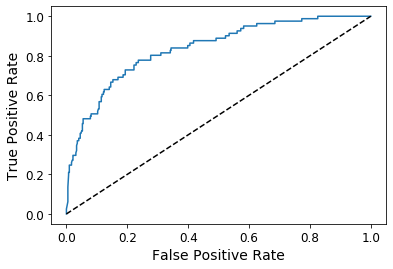

In [212]:
# Generate the probabilities
y_pred_prob = m.predict_proba(X_valid)[:, 1]

# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr,tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

In [213]:
# Print the AUC
auc = roc_auc_score(y_valid, y_pred_prob)
print(auc)

0.8359409528860603


In [214]:
# Create the hyperparameter grid
param_grid = {'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': np.arange(10,100)}

# Call GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), param_grid)

# Fit the model
grid_search.fit(X_valid, y_valid)

print(grid_search.best_params_, grid_search.best_score_)

/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_features': 'log2', 'n_estimators': 10} 0.766


/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Create the hyperparameter grid
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Call RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_dist)

# Fit the model
random_search.fit(X,y)

# Print best parameters
print(random_search.best_params_)

In [ ]:
# Sort importances
sorted_index = np.argsort(importances)

# Create labels
labels = X.columns[sorted_index]

print(labels)

# Clear current plot
plt.clf()

# Create plot
plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()

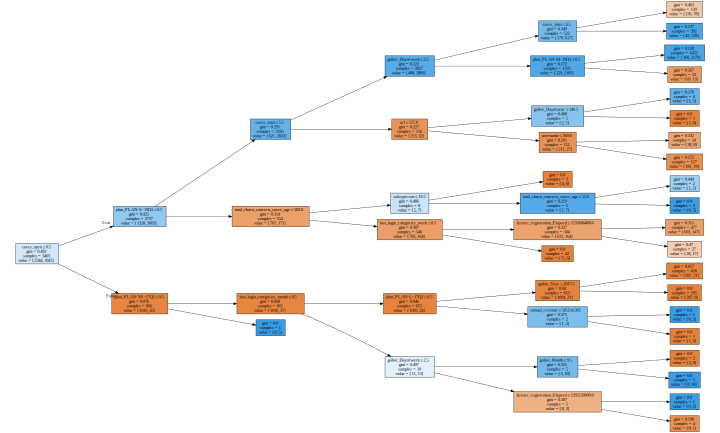

In [215]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [216]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
2,days_active,0.187194
12,cases_age_hours_total,0.115436
10,cases_open,0.084948
60,plan_PLAN-S-19Q1,0.081498
9,cases_total,0.076451
16,interactions_completed,0.073609
15,interactions_total,0.073393
11,cases_closed,0.063268
14,annual_revenue,0.026294
8,url,0.022069


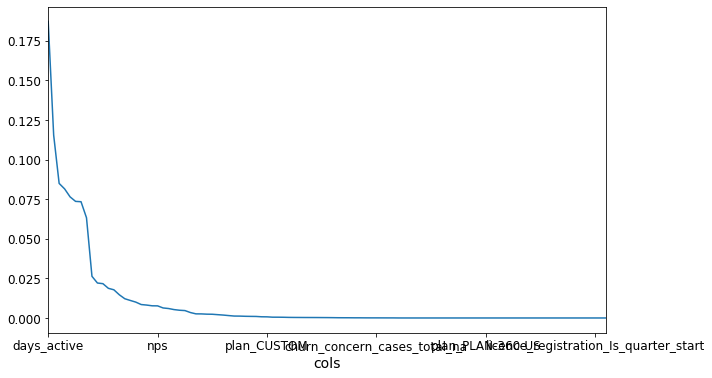

In [217]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [218]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

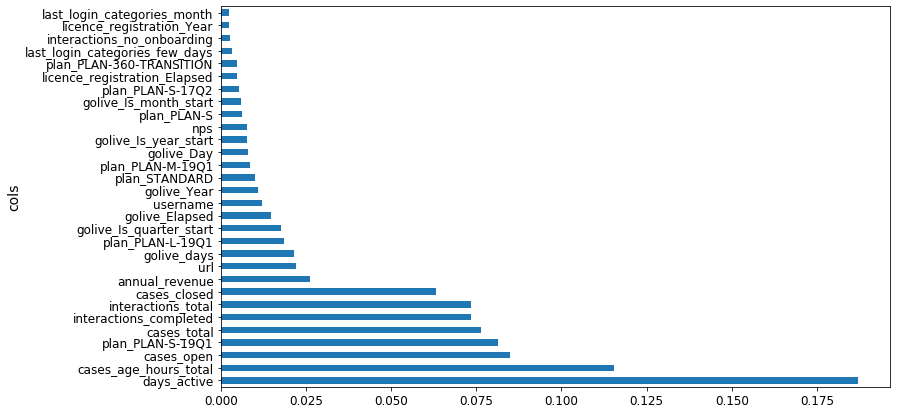

In [219]:
plot_fi(fi[:30]);

In [220]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [221]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [222]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train);
m.oob_score_

0.9434032287994062

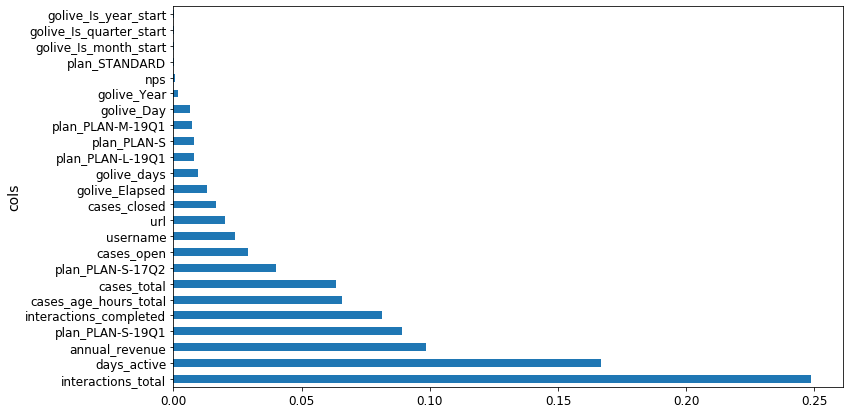

In [223]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [224]:
from scipy.cluster import hierarchy as hc

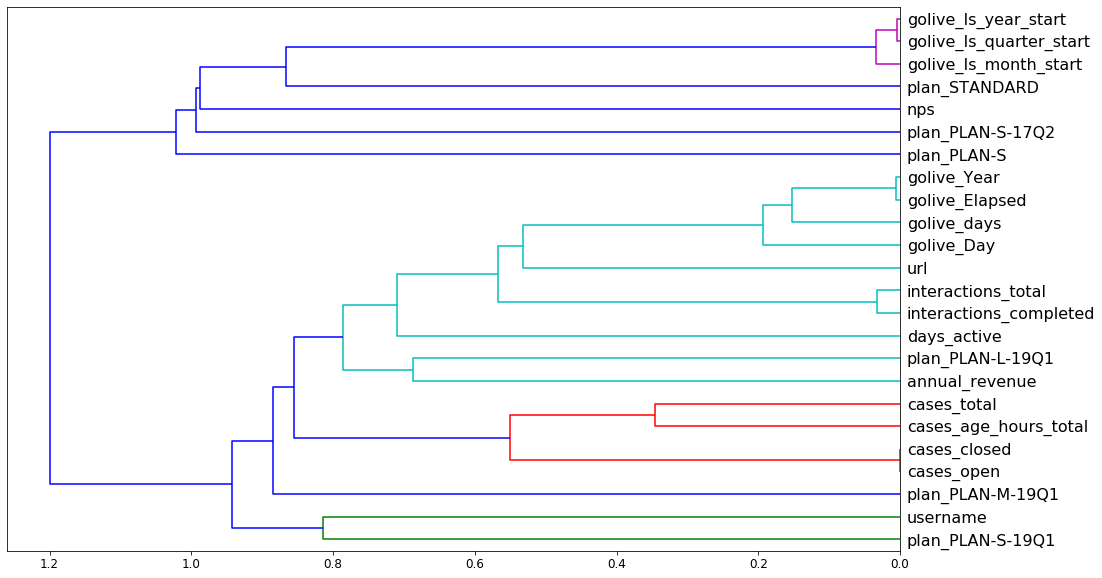

In [225]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [226]:
df_keep.columns

Index(['days_active', 'cases_age_hours_total', 'cases_open',
       'plan_PLAN-S-19Q1', 'cases_total', 'interactions_completed',
       'interactions_total', 'cases_closed', 'annual_revenue', 'url',
       'golive_days', 'plan_PLAN-L-19Q1', 'golive_Is_quarter_start',
       'golive_Elapsed', 'username', 'golive_Year', 'plan_STANDARD',
       'plan_PLAN-M-19Q1', 'golive_Day', 'golive_Is_year_start', 'nps',
       'plan_PLAN-S', 'golive_Is_month_start', 'plan_PLAN-S-17Q2'],
      dtype='object')

In [227]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [228]:
get_oob(df_keep)

0.9445166079049917

In [229]:
correlated_fields = ['cases_open', 'cases_closed']
for c in (df_keep):
    print(c, get_oob(df_keep.drop(c, axis=1)), get_oob(df_keep.drop(c, axis=1))-0.9660419372796437)

days_active 0.941733160141028 -0.025793282612729618
cases_age_hours_total 0.9445166079049917 -0.02356652440155871
cases_open 0.9467433661161625 -0.020040823900538074
plan_PLAN-S-19Q1 0.9460011133791056 -0.020411950269066614
cases_total 0.943217665615142 -0.02319539803303028
interactions_completed 0.9454444238263129 -0.0202263870848024
interactions_total 0.9458155501948413 -0.018927444794952675
cases_closed 0.9460011133791056 -0.021154203006123584
annual_revenue 0.943217665615142 -0.023009834848765953
url 0.9467433661161625 -0.01985526071627386
golive_days 0.9461866765633699 -0.021896455743180554
plan_PLAN-L-19Q1 0.9435887919836704 -0.02393765077008725
golive_Is_quarter_start 0.9450732974577843 -0.020411950269066614
golive_Elapsed 0.9454444238263129 -0.018927444794952675
username 0.9447021710892559 -0.021896455743180554
golive_Year 0.9443310447207274 -0.019298571163481215
plan_STANDARD 0.9456299870105771 -0.020783076637595044
plan_PLAN-M-19Q1 0.9461866765633699 -0.020783076637595044
gol

In [230]:
get_oob(df_keep.drop(correlated_fields, axis=1))

0.9441454815364632

In [231]:
to_drop = ['cases_closed', 'golive_Year']
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [233]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

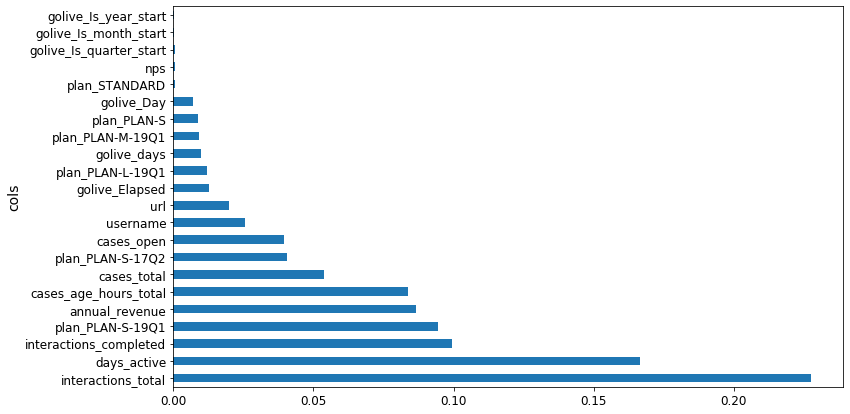

In [234]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);